# EDA for Chatbot Astrax

# Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer

try:
    from wordcloud import WordCloud
except:
    %pip install wordcloud
finally:
    from wordcloud import WordCloud

# Load Data

In [4]:
df = pd.read_csv("../data/imigrasi_combined_topics_full_context.csv")
df.head()

,topic,category,question,answer_link,answer,type,full_context
0,FAQ,M-Paspor,Apa yang harus saya lakukan jika aplikasi M-Pa...,https://www.imigrasi.go.id/faq/m-paspor/apa-ya...,Jika mengalami Request Timed Out (RTO) silakan...,faq,Question: Apa yang harus saya lakukan jika apl...
1,FAQ,M-Paspor,Apa yang harus saya lakukan jika tidak bisa lo...,https://www.imigrasi.go.id/faq/m-paspor/apa-ya...,"Apabila tidak dapat login M-Paspor, harap mema...",faq,Question: Apa yang harus saya lakukan jika tid...
2,FAQ,M-Paspor,Apa yang harus saya lakukan jika tidak bisa me...,https://www.imigrasi.go.id/faq/m-paspor/apa-ya...,Silakan menunjukkan QR Code dan bukti bayar ya...,faq,Question: Apa yang harus saya lakukan jika tid...
3,FAQ,M-Paspor,Bagaimana Cara Menutup Akun pada Aplikasi M-Pa...,https://www.imigrasi.go.id/faq/m-paspor/bagaim...,"Sebelum menghapus atau menutup akun M-Paspor, ...",faq,Question: Bagaimana Cara Menutup Akun pada Apl...
4,FAQ,M-Paspor,Bagaimana caranya untuk mendapatkan kuota pada...,https://www.imigrasi.go.id/faq/m-paspor/bagaim...,Kuota yang terdapat pada aplikasi M-Paspor mer...,faq,Question: Bagaimana caranya untuk mendapatkan ...


# Analysis

## 1. Dataset Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1582 entries, 0 to 1581
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   topic         1582 non-null   object
 1   category      1582 non-null   object
 2   question      1582 non-null   object
 3   answer_link   1582 non-null   object
 4   answer        1579 non-null   object
 5   type          1582 non-null   object
 6   full_context  1579 non-null   object
dtypes: object(7)
memory usage: 86.6+ KB


In [ ]:
df = df.dropna()

### Rows with non-standard Answers

In [5]:
# Answer is "Tidak ada jawaban."
non_standard_mv = ["Tidak ada jawaban."]

no_answer_rows = df[df['answer'].str.strip() == "Tidak ada jawaban."]
no_answer_rows[['question', 'answer']]

,question,answer


In [6]:
# Answer contains "Jawaban untuk....."

non_standard_mv = ["Jawaban untuk "]
redirected_answer_rows = df[df['answer'].str.contains('|'.join(non_standard_mv), case=False, na=False)]

redirected_answer_rows[['question', 'answer']]
print(f'\nThere are a total of {len(redirected_answer_rows)} questions where the Answer contains "Jawaban untuk.....": \n')
for index, row in redirected_answer_rows.iterrows():
    print(f"Answer of Q#{index}: {row['answer']}\n")


There are a total of 0 questions where the Answer contains "Jawaban untuk.....": 



## 2. Basic Text Statistics

### Distribution of question and Answer Lengths

In [7]:
df['question_len'] = df['question'].apply(len)
df['answer_len'] = df['answer'].apply(len)

q_stats = df['question_len'].describe().to_frame().rename(columns={'question_len': 'question Length'})
a_stats = df['answer_len'].describe().to_frame().rename(columns={'answer_len': 'Answer Length'})

combined_stats = pd.concat([q_stats, a_stats], axis=1)
combined_stats

,question Length,Answer Length
count,1579.000000,1579.000000
mean,118.293857,440.261558
std,34.765097,511.874455
min,13.000000,11.000000
25%,108.000000,162.000000
50%,123.000000,297.000000
75%,139.000000,692.000000
max,243.000000,10447.000000


questions tend to be concise, while answers range more broadly due to either short summaries or longer procedural instructions.

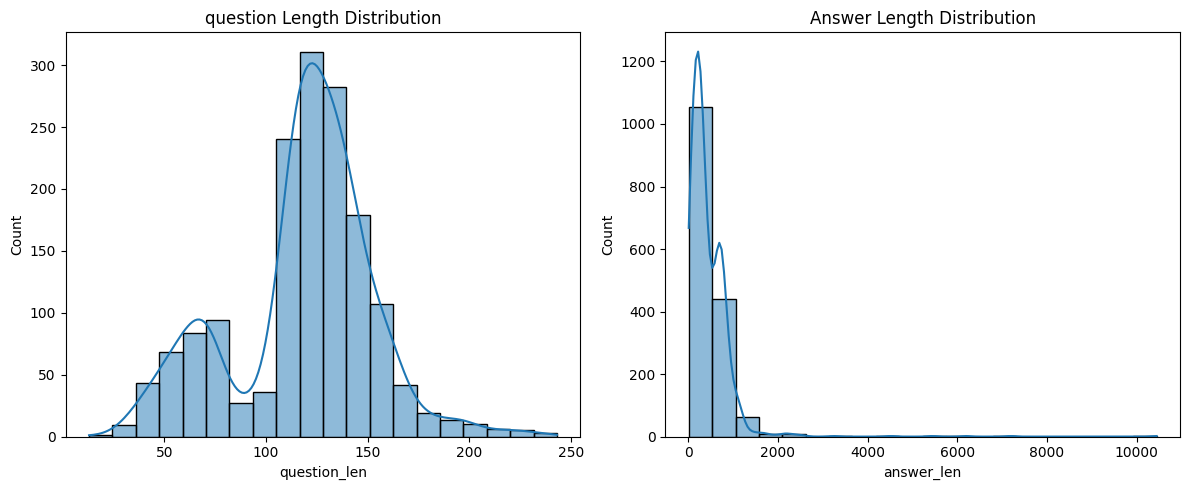

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['question_len'], bins=20, ax=axs[0], kde=True)
axs[0].set_title("question Length Distribution")
sns.histplot(df['answer_len'], bins=20, ax=axs[1], kde=True)
axs[1].set_title("Answer Length Distribution")
plt.tight_layout()
plt.show()

***SUMMARY***:

Most questions are relatively short and focused, while answers are relatively longer and show more variability in length. This reflects real-life FAQ structure, where questions are concise and answers can be detailed or link-based.

### Short questions with less than 30 characters

In [9]:
short_questions = df[df['question_len'] < 30]
print(f'Total = {len(short_questions)} questions')
short_questions[['question', 'question_len']]

Total = 4 questions


,question,question_len
13,Apa itu ABTC?,13
15,Berapa biaya pengurusan ABTC?,29
34,Apa itu Working-Holiday Visa?,29
74,Paspor Baru Luar Negeri Biaya,29


### Long questions with more than 100 characters

In [17]:
long_questions = df[df['question_len'] > 100]
print(f'Total = {len(long_questions)} questions')
long_questions['question'].unique()

Total = 1236 questions


array(['Saya telah mengunggah persyaratan Visa Online namun terdapat pemberitahuan bahwa dokumen belum terunggah',
       'Daftar Subjek VoA, BVK & Calling Visa Daftar Subjek Visa on Arrival Daftar Negara, Pemerintah Dari Daerah Administrasi Khusus Suatu Negara, dan Entitas Tertentu',
       'Daftar Subjek VoA, BVK & Calling Visa Daftar Subjek Bebas Visa Kunjungan Daftar Negara, Pemerintah Dari Daerah Administrasi Khusus Suatu Negara, dan Entitas Tertentu',
       ...,
       'Permohonan Visa Republik Indonesia Visa Tinggal Terbatas untuk Tokoh Dunia yang akan Mendirikan Perusahaan di Indonesia (Indeks E33D) Ketentuan-Ketentuan Lain',
       'Permohonan Visa Republik Indonesia Visa Tinggal Terbatas untuk Tokoh Dunia yang akan Mendirikan Perusahaan di Indonesia (Indeks E33D) Proses Pengajuan dan Pemberian Visa',
       'Permohonan Visa Republik Indonesia Visa Tinggal Terbatas untuk Tokoh Dunia yang akan Mendirikan Perusahaan di Indonesia (Indeks E33D) Komponen Biaya'],
      dtype=objec

### Long answers with more than 1,000 characters

In [ ]:
long_answers = df[df['answer_len'] > 1000]
print(f"Total long answers more than 1000 chars = {len(long_answers)} questions\n")
print("########################### Examples:")

# show only 3 examples
for i, (index, row) in enumerate(long_answers.iterrows()):
    print(f"Q: {row['question']}\nA: {row['answer']}\n")
    if i == 2:
        break

Total long answers more than 1000 chars = 86 questions

########################### Examples:
Q: Bagaimana prosedur permohonan paspor anak berkewarganegaraan ganda?
A: Anak berkewarganegaraan ganda terbatas yang lahir sebelum 1 Agustus 2006Jika belum melakukan pendaftaran tetap, anak harus memiliki izin keimigrasian. Penyelesaiannya cukup dilakukan di kantor imigrasi setempat.Jika telah melakukan pendaftaran tetap, hal-hal berikut harus diperhatikan.Orang tua/wali melapor ke kantor imigrasi setempat dengan melampirkan paspor dan Surat Keputusan Menteri tentang perolehan kewarganegaraan ganda terbatas.Orang tua/wali mengembalikan dokumen imigrasi.Anak yang berkewarganegaraan ganda dapat diberikan paspor RI dengan dibubuhi cap dalam paspor sebagai anak berkewarganegaraan ganda berdasarkan UU Nomor 12 Tahun 2006 pasal 4 huruf c, d, h, dan l serta pasal 5.Anak yang memiliki paspor kebangsaan lain harus melampirkan afidavit dengan biaya Rp400.000. Anak berkewarganegaraan ganda terbatas yang

C:\Users\galuh\AppData\Local\Temp\ipykernel_29272\3859774624.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_answers['length_bin'] = pd.cut(long_answers['answer_len'], bins)


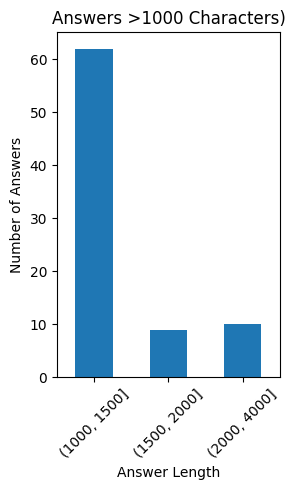

In [ ]:
bins = [1000, 1500, 2000, 4000]
long_answers['length_bin'] = pd.cut(long_answers['answer_len'], bins)
bin_counts = long_answers['length_bin'].value_counts().sort_index()

plt.figure(figsize=(3, 5))
bin_counts.plot(kind='bar')
plt.xlabel("Answer Length")
plt.ylabel("Number of Answers")
plt.title("Answers >1000 Characters)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Duplicate Detection

In [ ]:
duplicate_questions = df[df.duplicated('question')]
duplicate_answers = df[df.duplicated('answer')]

print(f"Duplicate questions: {len(duplicate_questions)}")
print(f"Duplicate answers: {len(duplicate_answers)}")

Duplicate questions: 0
Duplicate answers: 777


## 4. Keyword Frequency

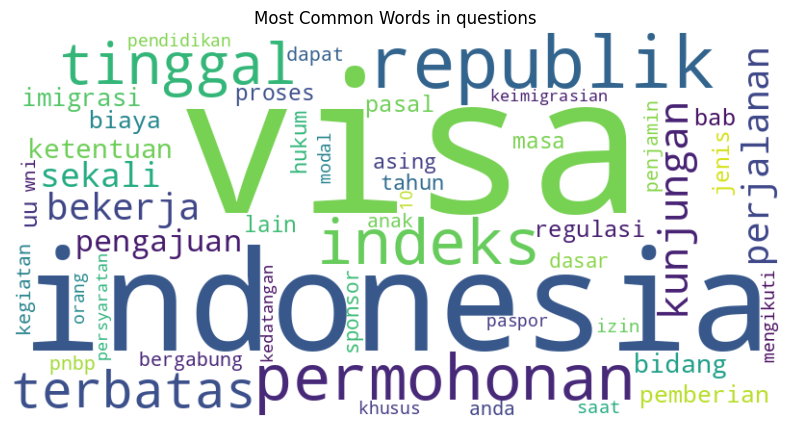

In [ ]:
custom_stopwords = ['yang', 'dan', 'di', 'ke', 'dari', 'untuk', 'dengan', 'pada', 'adalah', 'oleh', 'atau', 'jika', 'karena', 'akan', 'ini', 'itu', 'sebagai', 'dalam']

vectorizer = CountVectorizer(stop_words=custom_stopwords, max_features=50)
X = vectorizer.fit_transform(df['question'])
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in questions")
plt.show()

## 5. Link Presence in Answers

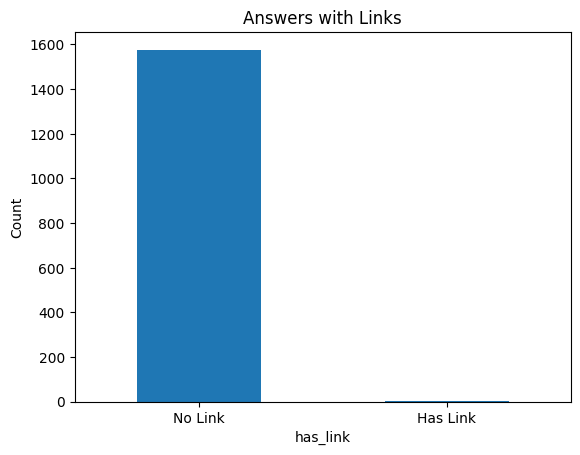

In [ ]:
df['has_link'] = df['answer'].apply(lambda x: bool(re.search(r'https?://', x)))
df['has_link'].value_counts().plot(kind='bar', title='Answers with Links')
plt.xticks(ticks=[0, 1], labels=['No Link', 'Has Link'], rotation=0)
plt.ylabel("Count")
plt.show()

Some number of answers contain links. These are mainly references to official documents. These links can be useful for chatbot to redirect users for a more complete answer.

## 6. Topic Distribution

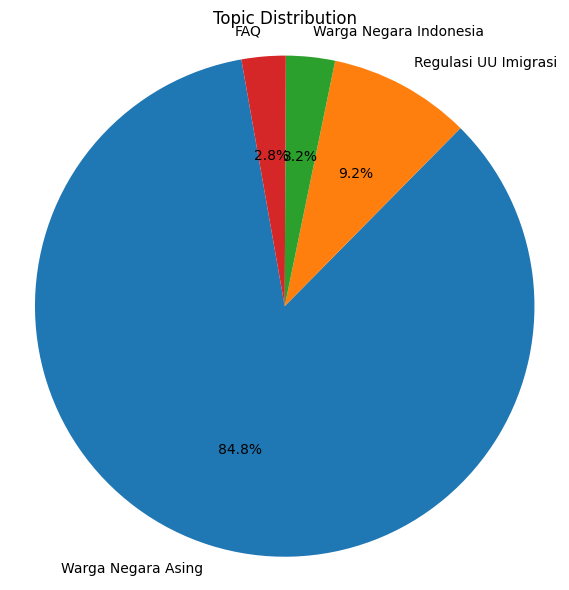

In [ ]:
topic_counts = df['topic'].value_counts()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    topic_counts.values,
    labels=topic_counts.index,
    autopct='%1.1f%%',
    startangle=100
)
plt.title("Topic Distribution")
plt.axis('equal')  # Ensures the pie chart is circular
plt.tight_layout()
plt.show()

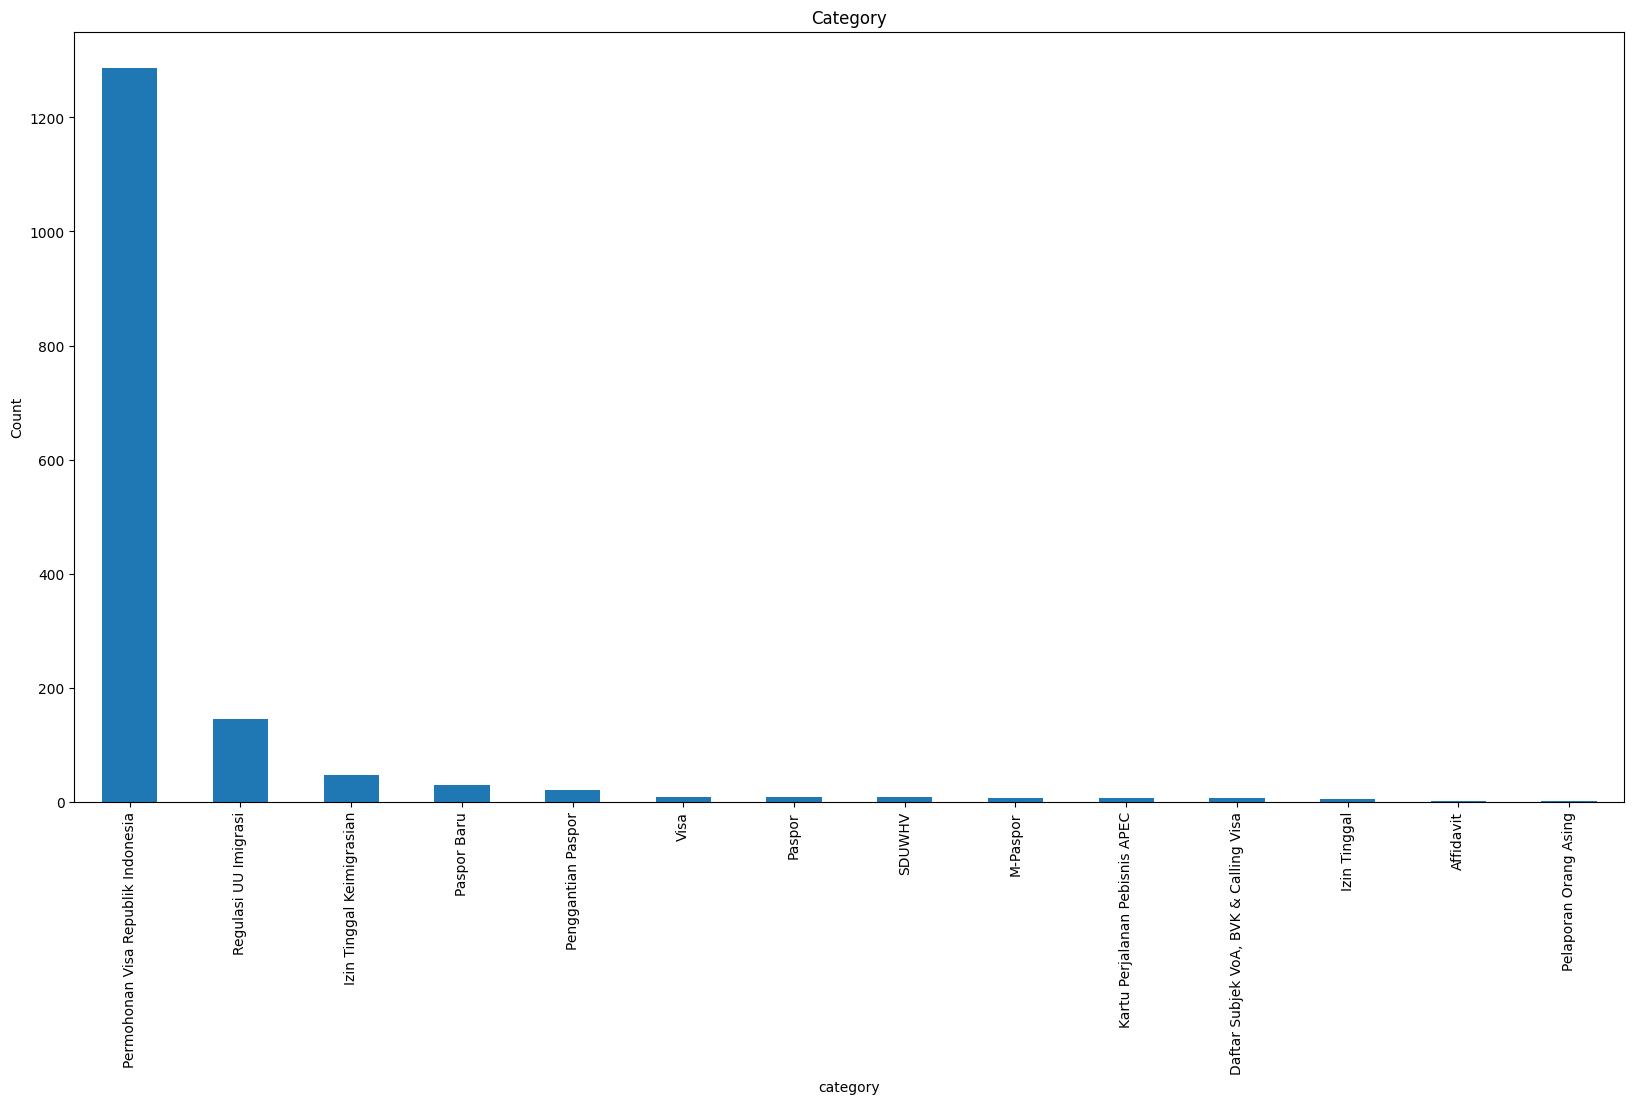

In [ ]:
topic_counts = df['category'].value_counts()

plt.figure(figsize=(20, 10))
topic_counts.plot(kind='bar', title='Category')
plt.ylabel("Count")
plt.show()

## 7. Average Length per Topic

C:\Users\galuh\AppData\Local\Temp\ipykernel_29272\4086078580.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=char_count_data.values, y=char_count_data.index, palette="viridis")


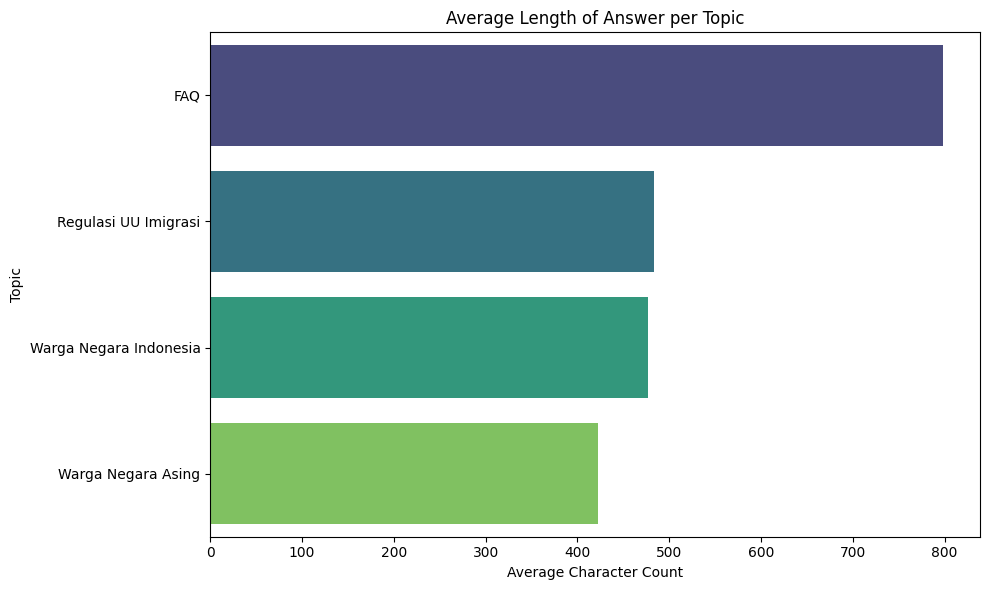

In [ ]:
char_count_data = df.groupby('topic')['answer_len'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=char_count_data.values, y=char_count_data.index, palette="viridis")
plt.title("Average Length of Answer per Topic")
plt.xlabel("Average Character Count")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

In [ ]:
sampled_questions = df.groupby('topic').apply(
    lambda x: x[['topic', 'question']].sample(n=min(len(x), 3), random_state=92)
).reset_index(drop=True)

display(sampled_questions)

C:\Users\galuh\AppData\Local\Temp\ipykernel_29272\2749603040.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_questions = df.groupby('topic').apply(


,topic,question
0,FAQ,Apa yang harus saya lakukan jika paspor saya h...
1,FAQ,Apa itu Working-Holiday Visa?
2,FAQ,Bagaimana jika status pembayaran di M-Paspor s...
3,Regulasi UU Imigrasi,Regulasi UU Imigrasi BAB 11 - Ketentuan Pidana...
4,Regulasi UU Imigrasi,Regulasi UU Imigrasi BAB 3 - Masuk dan Keluar ...
5,Regulasi UU Imigrasi,Regulasi UU Imigrasi BAB 12 - Biaya Pasal 138
6,Warga Negara Asing,Permohonan Visa Republik Indonesia Bebas Visa ...
7,Warga Negara Asing,Permohonan Visa Republik Indonesia Bebas Visa ...
8,Warga Negara Asing,Permohonan Visa Republik Indonesia Visa Tingga...
9,Warga Negara Indonesia,Paspor Baru Luar Negeri Informasi Umum
